Named entity recogniton with lstm 

#### data reading and data preprocessing 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras

/Users/es.py/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/es.py/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/es.py/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/es.py/.pyenv/versions/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py

#### check if we have gpu and preform the proper hyperparameter validation

In [2]:
if tf.test.is_gpu_available():
    BATCH_SIZE = 512
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 40 
else: 
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [3]:
data = pd.read_csv("./../week2/data/Ner-with-lstm/ner_dataset.csv.zip", encoding='latin1')

In [4]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


Here is the dataaset we are dealing with .

In [5]:
data = data.fillna(method='ffill')

we have how many tags? M

In [6]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

WE have errond 17 lables

let see how the data looks like : 

In [7]:
data.head(7)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo


For each sentence in the data we can need to get pos , and tag in for eas word

In [8]:
class SentenceGetter(object):
    """
    This convert the dataset into sentence 
    """
    def __init__(self, data):
        self.n_sentence = 1 
        self.empty = False
        self.data = data
        agg_func  = lambda row: [(word, pos, tag) for word, pos,tag in zip(row.get('Word').values.tolist(), row.get('POS').values.tolist(), row.get('Tag').values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences  = [sentence for sentence in self.grouped ]
    def get_next(self):
        try:
            sentence = self.grouped.get(f"Sentence: {self.n_sentence}")
            self.n_sentence +=1
            return sentence
        except Exception as exp:
            print(exp, "===" * 10)
            return None

In [9]:
getter = SentenceGetter(data)
sentence = getter.get_next()
print('This is what a sentence looks like \n: {}'.format(sentence))

This is what a sentence looks like 
: [('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


For better visualisation let write it like this

In [10]:
tokens = [ item [0] for item in sentence]
pos = [ item [1] for item in sentence]

In [11]:
tag = [ item [2] for item in sentence]

In [12]:
print(tokens)

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']


In [13]:
print(tag)

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


Now we can plot the number of samples vs len( number of tokens)

In [14]:
sentences = getter.sentences

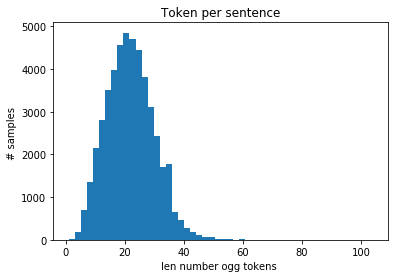

In [15]:
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel("len number ogg tokens ")
plt.ylabel("# samples ")
plt.show()

In [16]:
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

Number of words in the dataset:  35178
Tags: ['I-org', 'I-per', 'B-art', 'I-gpe', 'I-eve', 'B-per', 'I-geo', 'B-geo', 'I-tim', 'B-eve', 'O', 'I-nat', 'B-org', 'B-tim', 'I-art', 'B-nat', 'B-gpe']
Number of Labels:  17


In [17]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word_to_index = {word: index + 2 for index, word in enumerate(words)}
word_to_index["UNK"] = 1 # Unknown words
word_to_index["PAD"] = 0 # Padding


In [18]:
# Vocabulary Key:token_index -> Value:word
index_to_word = {index: word for word, index in word_to_index.items()}
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag_to_index = {tag: index+1 for index, tag in enumerate(tags)}
tag_to_index["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
index_to_tag = {index: word for word, index in tag_to_index.items()}
print("The word Obama is identified by the index: {}".format(word_to_index["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag_to_index["B-geo"]))


The word Obama is identified by the index: 24318
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 8


In [19]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word_to_index.get(word[0]) for word in sentence] for sentence in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word_to_index.get("PAD"))
# Convert Tag/Label to tag_index
y = [[tag_to_index.get(word[2]) for word in sentence] for sentence in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag_to_index.get("PAD"))


In [20]:
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

ModuleNotFoundError: No module named 'numpy.testing.nosetester'